In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import json
import os 

### The probabilistic reversal learning task

During the fMRI scanning session participants carried out the PRL task in two conditions: (1) reward-seeking and (2) punishment-avoiding. Participants were instructed to repeatedly choose between yellow and blue boxes in order to collect as many points as possible in the reward-seeking condition or loose as little points as possible in the punishment-avoiding condition (**Fig. 1**). One of the boxes had the probability to be correct (rewarding or non-punishing depending on the condition) p = 0.8 and the other one p = 0.2. This reward contingency changed four times throughout each task condition. Reward probabilities were unknown to the subjects and had to be learned from experience. Each box had also associated reward magnitude, randomly selected at the beginning of each trial. These reward magnitudes represented as numbers within the box indicated possible gain in the reward-seeking condition or possible loss in the punishment-avoiding condition. To be successful in this task decision maker had to correctly estimate reward probabilities from experience and take into account reward magnitudes to choose an option with higher expected value. 
    
Each task condition was associated with the separate fMRI run and consisted of N=110 trials. Each trial began with the decision phase indicated by the question mark appearing within the fixation circle. During decision phase subject had 2 s to choose one of the boxes by pressing button on the response grip with either left or right thumb. Decision phase was followed by a variable inter-stimulus-interval (ISI; 3-7 s, jittered), after which an outcome was presented for 2 s. During the outcome phase fixation circle was colored accordingly to rewarded or punished box and the number within the circle represented number of gained or lost points (see **Fig. 1**). Outcome phase was followed by a variable inter-trial-interval (ITI; 3-7 s, jittered). 
    
    
The number of points which subject gathered in the reward-seeking condition or the remaining number of points in the punishment-avoiding conditions was represented by the gray account bar on the bottom of the screen. Subjects were informed that if they manage to fill half of the bar or the entire bar in the reward-seeking condition they will receive 10 PLN or 20 PLN respectively. In the punishment-avoiding condition subjects were informed that they will receive 20 PLN if they are left with more than half of the bar, 10 PLN if they are left with less than half of the bar or that do not receive any money if they lose all of their points. To maintain constant level of motivation throughout the task, incentives thresholds were set such that all participants acquired 10 PLN from either task.


PsychoPy software (v. 1.90.1, www.psychopy.org (Peirce, 2007)) was used for task presentation on the MRI compatible NNL goggles (NordicNeuroLab, Bergen, Norway). Behavioral responses were collected using MRI compatible NNL response grips (NordicNeuroLab, Bergen, Norway), which were hold in both hands.  Each condition lasted approximately 24 min. The order of task conditions as well as the colors for left and right box (yellow and blue) were counterbalanced across subjects. Before the MRI scan, subjects practiced both task conditions on the lab computer. 
Heterogeneity in the prior expectations regarding the task structure may lead to heterogeneity in behavior even in simple tasks leading to inaccurate behavioral modelling (Shteingart and Loewenstein, 2014). To tackle this challenge, we explicitly instructed participants that one of the boxes will be more frequently rewarded in the reward-seeking condition or punished in the punishment-avoiding condition and that this contingency may reverse several times during the task. In order to further ensure that participants grasp correct model of the task environment, they were provided with the feedback indicating which box is more frequently correct during the first phase of the training. 

![Figure 1](image/fig_1.png)


### Processing of log dataframe

Each row of a dataframe represents *single trial*.
Description of useful dataframe columns:

Task characteristics:
- `block`: indicates which box is currently more likely to be rewarded / punished 
   - coding: -1 = left, 1 = right
   - being chosen interpretation
- `rwd`: indicates which box is rewarded / punished on a given trial
   - coding: -1 = left, 1 = right
   - being chosen interpretation
- `magn_left` and `magn_right`: visible reward magnitudes

Subject responses:
- `response`: subject response
   - coding: -1 = left, 0 = miss, 1 = right
- `rt`: reaction time (max. 1.5 seconds)
   - coding: nan for miss
- `won_bool`: indicates if subject won / not loose points
   - coding: 1 = won / not lost, 0 = lost / not won
- `won_magn`: indicates number of points won / lost
   - magnitude in points change (can be negative)
- `acc_after_trial`: subject total points after given trial

Task timing: 
- `onset_[iti/dec/isi/out]`: time registered with fmri clock
    - used for analysis
- `onset_[iti/dec/isi/out]_plan`: planned time for stimulus presentation (always slightly behind registered time)
- `onset_[iti/dec/isi/out]_glob`: time registered with global clock (only for synchronization validation purpose, not used for analysis) 

Function `process_log_df()` cleans behavioral response dataframe changing data types, inverting interpretation of certain variables depending on task condition and drops irrelevant columns.

In [ ]:
def process_log_df(df):
    '''Cleaning and pre-processing of log dataframe.
    
    Args:
        df (pd.Dataframe): raw log dataframe
        
    Returns:
        info (dictionary): contains task metadata
        df_clean (pd.Dataframe): pre-processed log dataframe
    '''
    df_clean = df.copy(deep=True)
    
    # Convert subject responses to integers
    df_clean.loc[df['response'] == 'a', 'response'] = -1
    df_clean.loc[df['response'] == 'd', 'response'] = 1
    try:
        df_clean.loc[df_clean['response'] == 'None', 'response'] = 0
    except TypeError:
        print('No missing responses.')

    # Convert reaction time to float
    df_clean['rt'] = pd.to_numeric(df_clean['rt'], errors='coerce')

    # Grab additional info                                                   
    info = {}
    info['n_trials'] = df_clean.shape[0]
    info['n_blocks'] = 5                                                     #TODO grab from data
    info['condition'] = df_clean['condition'][0]
    info['subject'] = df_clean['subject_id'][0]
    info['group'] = df_clean['group'][0]

    # Reverse the punishing interpretation of columns in punishment condition 
    # NOTE! 'block' and 'rwd' still have BEING CHOSEN interpretation
    if info['condition'] == 'pun':
        df_clean['won_magn'] *= (-1)  
        df_clean['won_bool'] = ~ df_clean['won_bool'] 
        df_clean['magn_left'] *= (-1)
        df_clean['magn_right'] *= (-1)

    # Drop unnecessary columns
    df_clean = df_clean[['block', 'rwd', 'magn_left', 'magn_right',
                         'response', 'rt',
                         'won_bool', 'won_magn', 'acc_after_trial',
                         'onset_iti', 'onset_iti_plan', 'onset_iti_glob',
                         'onset_dec', 'onset_dec_plan', 'onset_dec_glob',
                         'onset_isi', 'onset_isi_plan', 'onset_isi_glob',
                         'onset_out', 'onset_out_plan', 'onset_out_glob']]

    return info, df_clean

(1) load logs for all subjects 

(2) cleaning them using `process_log_df()` function

(3) aggregate them to single list containing all dataframes accompanied with metadata

In [ ]:
path_logs = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study/task_logs"
subjects = ['m02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 
            'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 
            'm20', 'm21', 'm22', 'm23', 'm24', 'm25', 'm26', 'm27', 'm28', 
            'm29', 'm30', 'm31', 'm32', 'm33']
df_all_rew, df_all_pun = [], []

for subject in subjects:

    # Load behavioral responses for signle subject
    path_rew = f"{path_logs}/sub-{subject}/{subject}_prl_DecideNet_rew.csv"
    path_pun = f"{path_logs}/sub-{subject}/{subject}_prl_DecideNet_pun.csv"

    df_rew = pd.read_csv(path_rew)
    df_pun = pd.read_csv(path_pun)

    # Clean behavioral responses
    info_rew, df_rew = process_log_df(df_rew)
    info_pun, df_pun = process_log_df(df_pun)

    df_all_rew.append((info_rew, df_rew))
    df_all_pun.append((info_pun, df_pun))

### Create single variable to represent all behavioral responses
Use aggregated lists of clean dataframes (`df_all_rew` and `dr_all_pun`) and convert them to single numpy array representing all behavioral responses and task onsets. Size of aggregated array is: n_subjects x n_conditions x n_trials x 21. Array metadata decoding dimensions is stored in variable `meta`.

In [ ]:
out_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study/behavioral"
filename = "behavioral_data_clean_all"

beh = np.zeros((len(subjects), 2, 110, 21))

# create & save metadata
meta = {}
meta['dim1'] = subjects
meta['dim2'] = ['rew', 'pun']
meta['dim3'] = [f'trial_{i+1}' for i in range(110)]
meta['dim4'] = list(df_all_rew[0][1].keys())

meta_path = os.path.join(out_path, f"{filename}.json")
with open(meta_path, 'w') as f:
    json.dump(meta, f, indent=4)

# create & save numpy aggregated array
for i, (df_rew, df_pun) in enumerate(zip(df_all_rew, df_all_pun)):
    beh[i, 0] = np.array(df_rew[1], dtype='float')
    beh[i, 1] = np.array(df_pun[1], dtype='float')
    
beh_path = os.path.join(out_path, f"{filename}.npy")
np.save(beh_path, beh)

### Visualisation of subject responses
Function `plot_response()` creates friendly visualisation of subject responses throughout the task. Visualisation consists of:
- **top panel**: represents internal task structure
    - blue and yellow blocks show stable phases for which box reward probabilities do not change (color is coding more profitable side; blue=left, yellow=right)
    - dark blue line show reward magnitude for the left box
    - yellow and blue dots show winning sides (rewarded / not punished)
- **middle panel**: represents subject's reaction times and account balance
    - red line: reaction time, 
    - red rectangles: highlight misses
    - black dashed line: account balance throughout the task
    - dark shaded area: trials for which subject crossed reward threshold
- **bottom panel**: represetnes subject's trialwise responses 
    - green dot = rewarded / not punished; red dot = not rewarded / punished
    - dark dashed line: idle time (how many stable trials subject experienced)
    - colored rectangles: which side is more profitable in terms of reward magnitude

Load aggregated behavioral data.

In [88]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/behavioral/behavioral_data_clean_all.npy"
beh_meta_path = beh_path.replace('npy', 'json')

# Load behavioral data
beh = np.load(beh_path)
with open(beh_meta_path, 'r') as f:
    meta = json.loads(f.read())
    
print("Shape of beh array:", beh.shape)
print("Conditions", [(i, cond) for i, cond in enumerate(meta['dim2'])])
print("Columns:", [(i, col) for i, col in enumerate(meta['dim4'])])

n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


In [106]:
def plot_response(beh, meta, subject, condition, save=False, **kwargs):
    '''Visualising useful aspects of subjects responses.
    
    Args:
        beh (np.array): aggregated behavioral responses
        meta (dict): description of beh array coding
        subject (int): subject index
        condition (int): task condition index
            0 for reward condition or 1 for punishment condition
        save (bool): should I save your plot?
        ...
        **out_path (Str): path to folder to save plot
    '''
    col_blu = "#56B4E9" # left
    col_yel = "#F0E442" # right
    col_blu_d = "#0B3A54"
    
    # Get proper task & response features
    block_vec = beh[subject, condition, :, 0]
    rwd_vec = beh[subject, condition, :, 1]
    magn_left_vec = beh[subject, condition, :, 2]
    magn_right_vec = beh[subject, condition, :, 3]
    response_vec = beh[subject, condition, :, 4]
    rt_vec = beh[subject, condition, :, 5]
    won_bool_vec = beh[subject, condition, :, 6]
    acc_after_trial_vec = beh[subject, condition, :, 8]
    magn_diff = magn_right_vec - magn_left_vec

    n_blocks = np.nonzero(np.diff(block_vec))[0].shape[0] + 1
    n_trials = beh.shape[2]
    x_trials = np.arange(1, n_trials+1)
    
    # Determine begin and end of the blocks and rewarded side
    blocks = np.zeros((2, n_blocks+1), dtype='int')
    blocks[0, 0:n_blocks] = np.hstack((
        np.ones((1), dtype=int), 
        np.nonzero(np.diff(beh[subject, condition, :, 0]))[0] + 2
    ))
    blocks[0, n_blocks] = n_trials
    blocks[1, 0:n_blocks] = beh[subject, condition, blocks[0][:-1], 0]

    if condition == 1: blocks[1, :] *= (-1) 


    # Create plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, 
                                        figsize=(20, 10), facecolor='w')

    ### Subplot 1 ###########################################################
    # True reward contingencies (more profitable side)
    for i in range(n_blocks):

        if blocks[1, i] == -1:  col = col_blu
        else:                   col = col_yel

        ax1.fill_between(
            x=[blocks[0, i], blocks[0, i+1]], 
            y1=-1, y2=1, 
            color=col, alpha=.5)

    # Rewarded / punished side
    if condition == 1:    
        ax1.scatter(x_trials, (-1)*rwd_vec*.9, c=(-1)*rwd_vec, 
                    cmap='cividis', vmin=-1.5, vmax=1.5)
    else: 
        ax1.scatter(x_trials, rwd_vec*.9, c=rwd_vec, 
                    cmap='cividis', vmin=-1.5, vmax=1.5)
    ax1.set_ylim(-1, 1)
    ax1.set_yticks([-0.9, 0.9])
    ax1.set_yticklabels(['left', 'right'])
    ax1.set_ylabel('Better option')

    # Magnitude for left box
    ax1b = ax1.twinx()
    ax1b.plot(x_trials, magn_left_vec, color=col_blu_d)
    ax1b.set_ylabel('$x(t)$ for left box', color=col_blu_d)
    ax1b.set_xlim(1, n_trials)
    if condition == 1: 
        ax1b.set_ylim(-50, 0)
    else:               
        ax1b.set_ylim(0, 50)
    ax1b.set_xlim(1, n_trials)

    ### Subplot 2 ###########################################################
    # Misses
    for miss in np.argwhere(np.isnan(rt_vec)):

        ax2.fill_between(
            x=[miss[0]+.5, miss[0]+1.5],
            y1=0, y2=1.5,
            color='r', alpha=.5)

    # Reaction times
    ax2.plot(x_trials, rt_vec, 'r')
    ax2.set_ylabel('reaction time $[s]$', color='r')
    ax2.set_xticks(blocks[0, 1:-1])
    ax2.set_ylim(0, 1.5)
    ax2.grid(axis='x')

    # Account
    ax2b = ax2.twinx()
    ax2b.plot(x_trials, acc_after_trial_vec, 'k--')
    ax2b.set_ylabel('account balance')

    # Crossing predefined task threshold
    if condition == 1:
        acc_thr = np.ones(x_trials.shape) * 650
        ax2b.fill_between(x_trials, acc_after_trial_vec, acc_thr, 
                          where=acc_after_trial_vec <=acc_thr,
                          color='k', alpha=.2)
    else:
        acc_thr = np.ones(x_trials.shape) * 1150
        ax2b.fill_between(x_trials, acc_after_trial_vec, acc_thr, 
                      where=acc_after_trial_vec >=acc_thr,
                      color='k', alpha=.2)

    ### Subplot 3 ###########################################################
    # Idle time (repeated winning / not loosing side)
    idle = np.zeros(rwd_vec.shape)
    for i in range(1, len(rwd_vec)):
        current = rwd_vec[i]
        last_trials = np.flip(rwd_vec[:i] == current)
        t = 0
        while last_trials[t] == True: 
            t += 1
            if t == len(last_trials): 
                break
        if condition == 1:  idle[i] = t * current * (-1)
        else:               idle[i] = t * current

    ax3.plot(x_trials, idle, 'k')
    ax3.set_ylim(-np.max(np.abs(idle)) - 2, np.max(np.abs(idle)) + 2)
    ax3.set_ylabel('Idle time')

    # Difference in magnitude
    norm = matplotlib.colors.Normalize(-45, 45)
    colors = [[norm(-45), col_blu],
              [norm(0), "white"],
              [norm(45), col_yel]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

    ax3b = ax3.twinx()
    for trial in range(n_trials):
        ax3b.fill_between(
            x=[trial+.5, trial+1.5], 
            y1=-1, y2=1, 
            color=cmap(norm(magn_diff[trial])), alpha=.7)

    # Subject respnses
    ax3b.scatter(x_trials, response_vec*.75, c=won_bool_vec, 
                cmap='RdYlGn', vmin=-.2, vmax=1.2, s=50)
    ax3b.set_ylim(-1, 1)
    ax3b.set_yticks([-0.75, 0, .75])
    ax3b.set_yticklabels(['left', 'miss', 'right'])
    ax3b.grid(axis='both')    
    ax3b.spines['top'].set_color(col_yel)
    ax3b.spines['top'].set_linewidth(3)
    ax3b.spines['bottom'].set_color(col_blu)
    ax3b.spines['bottom'].set_linewidth(3)

    if save:

        if "out_path" in kwargs:  out_path = kwargs["out_path"] + "/"
        else:                     out_path = ""

        filename = f"{out_path}sub-{meta['dim1'][subject]}_{meta['dim2'][condition]}_respplot"
        plt.savefig(filename)    
        
        plt.close()

Show example plot.

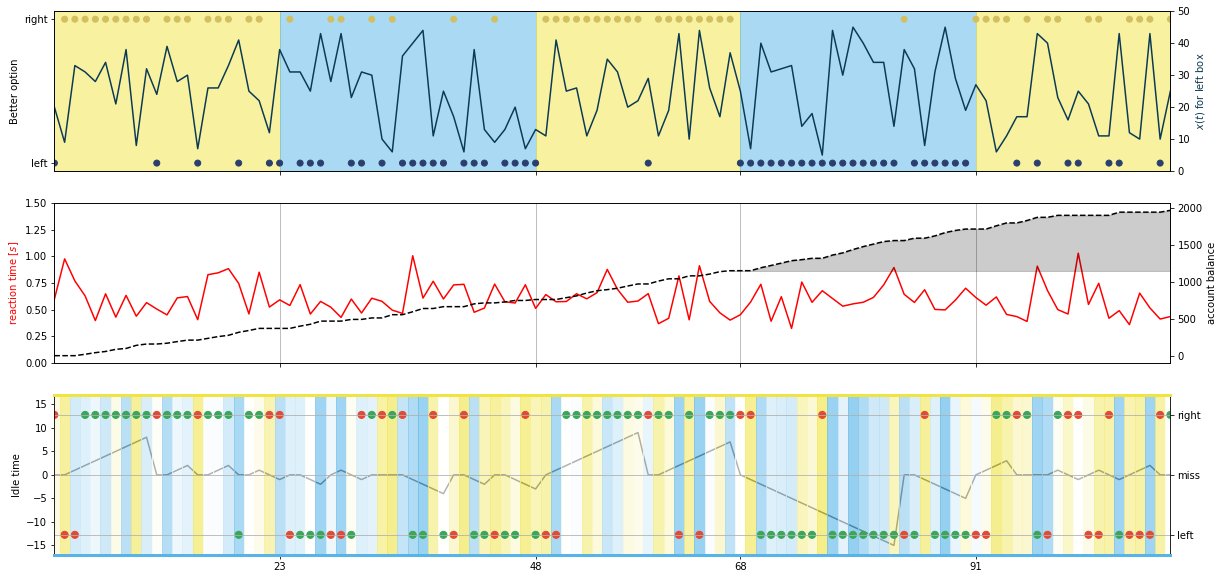

In [107]:
plot_response(beh, meta, 5, 0)

Generate and save response plots.

In [104]:
out_path = "/home/kmb/Desktop/Neuroscience/Projects/"\
           "BONNA_decide_net/code/behavioral_analysis/respplots"

for i in range(n_subjects):
    # Save respplots to file
    plot_response(beh, meta, i, 0, 
                  save=True, out_path=out_path);
    plot_response(beh, meta, i, 1,
                  save=True, out_path=out_path);